In [1]:
from dataset import *
from train import *


In [2]:
import os
import pandas as pd

import collections

import torch
import torch.optim as optim

In [32]:
# Set parameters
EuroSat_Type = 'ALL'    
target_country = 'France'

lr = 0.01               # learn_rate
milestones = [50,75,90] # multistep scheduler
epochs = 100            # no of epochs

output_path = "./" + target_country

## Download data

In [33]:
# raw data
if EuroSat_Type == 'RGB':
  data_folder = '/content/sample_data/'
  #root = os.path.join(data_folder, '2750/')
  root = '2750/'
  download_ON = os.path.exists(root)

  if not download_ON:
    # This can be long...
    #os.chdir(data_folder)
    os.system('wget http://madm.dfki.de/files/sentinel/EuroSAT.zip') #Just RGB Bands
    !unzip EuroSAT.zip
    download_ON = True
elif EuroSat_Type == 'ALL':
    root = 'ds/images/remote_sensing/otherDatasets/sentinel_2/tif/'
    download_ON = os.path.exists(root)
    if not download_ON:
      os.system('wget http://madm.dfki.de/files/sentinel/EuroSATallBands.zip') #All bands
      !unzip EuroSATallBands.zip
      download_ON = True
    
data = torchvision.datasets.DatasetFolder(root=root,loader = iloader, transform=None, extensions = 'tif')

In [34]:
# Metadata
geo_df = pd.read_csv("metadata.csv")
geo_dict = geo_df.to_dict()
countries = list(set(geo_dict["country"].values()))
id_countries = dict.fromkeys(countries)
for k in id_countries.keys():
    id_countries[k] = [v for (i, v) in enumerate(geo_dict["id"]) if geo_dict["country"][i] == k]

In [54]:
# source - target split
id_target = id_countries[target_country]
id_train = random.sample(id_target, 640)
id_test = list(set(id_target) - set(id_train))#[0:160]
id_test = random.sample(id_test, 160)

loader_target_train = torch.utils.data.DataLoader(torch.utils.data.Subset(data, id_train), 
                                                  batch_size = 16, shuffle = True, num_workers = 0)
loader_target_test = torch.utils.data.DataLoader(torch.utils.data.Subset(data, id_test), 
                                                  batch_size = 16, shuffle = True, num_workers = 0)

id_random_source = random.sample(list(geo_dict["id"].values()),
                                len(loader_target_train.dataset))
loader_random_source = torch.utils.data.DataLoader(torch.utils.data.Subset(data, id_random_source), 
                                                  batch_size= 16, shuffle=False, num_workers=0)

In [55]:
for indices in id_train, id_test, id_random_source:
    labels = [data.samples[i][1] for i in indices]
    print(collections.Counter(labels).values())

dict_values([232, 114, 71, 75, 62, 53, 33])
dict_values([67, 20, 16, 14, 14, 11, 18])
dict_values([119, 103, 75, 98, 83, 65, 97])


## Train

In [56]:
np.random.seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
print("pytorch version", torch.__version__)
criteria = torch.nn.CrossEntropyLoss()
net = Load_model()
if torch.cuda.is_available():
    net=net.cuda()
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

pytorch version 1.8.0
Model Loaded


In [57]:
#train_loader, val_loader, test_loader =Load_data(root)

Iteration Number 3600 413.7365689277649 seconds
Train (epoch 91/100) [0/40 (0%)]	Loss: 0.264503	Accuracy: 0.875	Learning Rate:1e-05


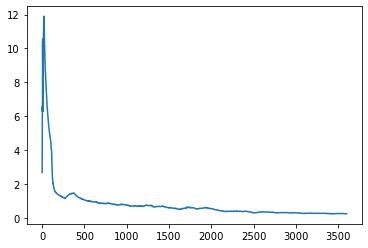

validation accuracy : 0.8875


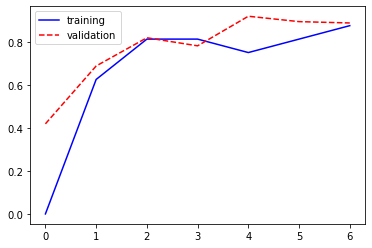

e= 92 28.594871044158936 seconds
e= 93 55.974483251571655 seconds
e= 94 83.34806609153748 seconds
e= 95 110.9291000366211 seconds
e= 96 138.5034339427948 seconds
e= 97 165.80178713798523 seconds
e= 98 193.22729897499084 seconds
e= 99 220.63120198249817 seconds
e= 100 247.95978212356567 seconds


In [58]:
net = train(net, loader_target_train, loader_target_test, criteria, optimizer, epochs, scheduler)

In [59]:
torch.save(net.state_dict(), output_path + "target_train.pt" )

Iteration Number 3600 453.012668132782 seconds
Train (epoch 91/100) [0/40 (0%)]	Loss: 2.452281	Accuracy: 0.125	Learning Rate:1e-05


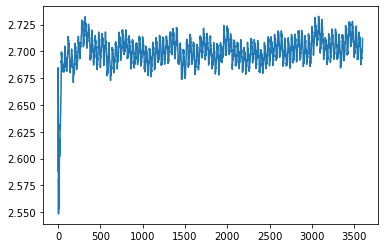

validation accuracy : 0.0375


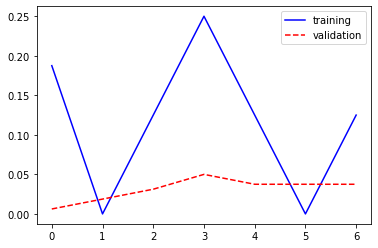

e= 92 31.10499882698059 seconds
e= 93 60.91528511047363 seconds
e= 94 91.0175130367279 seconds
e= 95 120.84897208213806 seconds
e= 96 150.72129678726196 seconds
e= 97 180.58401799201965 seconds
e= 98 210.49527883529663 seconds
e= 99 240.3258090019226 seconds
e= 100 270.1438248157501 seconds


In [60]:
net_random = Load_model()
net_random = train(net_random, loader_random_source, loader_target_test, criteria, optimizer, epochs, scheduler)
torch.save(net_random.state_dict(), output_path + "random_source" )